In [1]:
import warnings
import os
import logging
import sys

# Βελτίωση των εκτυπώσεων
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['PYTHONWARNINGS'] = 'ignore'
logging.getLogger("xgboost").setLevel(logging.WARNING)
sys.stdout.flush()

In [2]:
from babel.util import distinct
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import min, max, mean
from pyspark.sql.functions import when, col
import numpy as np
from pyspark.ml.feature import StringIndexerModel, VectorAssembler
from pyspark.sql.functions import col, lit
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, OneVsRest, GBTClassifier
from pyspark.ml.classification import  NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import date_format
from pyspark.storagelevel import StorageLevel
import psutil
import time
import threading
import builtins
from xgboost.spark import SparkXGBClassifier
from pyspark.sql.types import DoubleType
from imblearn.over_sampling import SMOTE
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

In [3]:
spark = SparkSession.builder.appName("Drought_NEW") \
    .master("local[*]") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.memory.fraction", "0.9") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

25/04/22 13:25:30 WARN Utils: Your hostname, dgour-HP-Laptop-15-db1xxx resolves to a loopback address: 127.0.1.1; using 192.168.1.56 instead (on interface wlo1)
25/04/22 13:25:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/22 13:25:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
full_data = spark.read.csv("train_timeseries.csv", header=True, inferSchema=True)

In [5]:
full_data = full_data.sample(fraction=0.01, seed=42)

In [6]:
# Στήλη score:Μετατροπή των NULL τιμών σε 0.0
full_data = full_data.withColumn("score", when(col("score").isNull(), 0.0).otherwise(col("score")))

# Multi-class Classification: Μετατροπή του score σε κατηγορίες(None, D0-D4)
full_data = full_data.withColumn(
    "Label",
    when(col("score") == 0.0, "None")
    .when((col("score") > 0.0) & (col("score") < 1.0), "D0")
    .when((col("score") >= 1.0) & (col("score") < 2.0), "D1")
    .when((col("score") >= 2.0) & (col("score") < 3.0), "D2")
    .when((col("score") >= 3.0) & (col("score") < 4.0), "D3")
    .when((col("score") >= 4.0) & (col("score") <= 5.0), "D4")
)

#Μετατροπή datatype ημερομηνίας:date->int
full_data = full_data.withColumn("date", date_format(col("date"), "yyyyMMdd").cast("int"))

labels_order = ["None", "D0", "D1", "D2", "D3", "D4"]  # Ορίζουμε ότι None=0, D0=1, D1=2, ...

# Μετατροπή της κατηγορικής μεταβλητής Label σε αριθμητική(0,1,2,3,4,5)
indexer = StringIndexerModel.from_labels(labels_order, inputCol="Label", outputCol="LabelIndex")

if 'LabelIndex' in full_data.columns:
    full_data = full_data.drop('LabelIndex')

full_data = indexer.transform(full_data)

feature_cols = ["fips", "date", "PRECTOT", "PS", "QV2M", "T2M",
                "T2MDEW", "T2MWET", "T2M_MAX", "T2M_MIN",
                "T2M_RANGE", "TS", "WS10M", "WS10M_MAX",
                "WS10M_MIN", "WS10M_RANGE", "WS50M",
                "WS50M_MAX", "WS50M_MIN", "WS50M_RANGE"]

# Τα features σε μορφή διανύσματος (Vector)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Z-score κανονικοποίηση
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

pipeline = Pipeline(stages=[
    assembler,
    scaler
])

# Fit και Transform 
pipeline_model = pipeline.fit(full_data)
full_data = pipeline_model.transform(full_data)

# Τελική επιλογή στηλών
final_data = full_data.select("scaled_features", "LabelIndex")

In [6]:
# Ορισμός κλάσης για την παρακολούθηση των τιμών των υπολογιστικών πόρων(CPU, memory, Disk I/O)

class ResourceMonitorListener:
    def __init__(self):
        self.cpu_percentages = []
        self.mem_percentages = []
        self.disk_reads = []
        self.disk_writes = []
        self.monitoring = False

    def start_monitoring(self):
        self.monitoring = True
        self.cpu_percentages = []
        self.mem_percentages = []
        self.disk_reads = [psutil.disk_io_counters().read_bytes]
        self.disk_writes = [psutil.disk_io_counters().write_bytes]

        # Δημιουργία thread: κάθε 1 δευτερόλεπτο ενημερώνει τις λίστες που περιέχουν τις τιμές των πόρων
        def monitor_loop():
            while self.monitoring:
                self.cpu_percentages.append(psutil.cpu_percent(interval=1))
                self.mem_percentages.append(psutil.virtual_memory().percent)
                disk_io = psutil.disk_io_counters()
                self.disk_reads.append(disk_io.read_bytes)
                self.disk_writes.append(disk_io.write_bytes)

        self.monitor_thread = threading.Thread(target=monitor_loop, daemon=True)
        self.monitor_thread.start()

    # Διακοπή του thread 
    def stop_monitoring(self):
        self.monitoring = False
        self.monitor_thread.join()

        self.disk_reads = [x for x in self.disk_reads if isinstance(x, (int, float))]
        self.disk_writes = [x for x in self.disk_writes if isinstance(x, (int, float))]

        # Υπολογισμός των τελικών τιμών
        cpu_avg = sum(self.cpu_percentages) / len(self.cpu_percentages) if self.cpu_percentages else 0
        mem_avg = sum(self.mem_percentages) / len(self.mem_percentages) if self.mem_percentages else 0

        # Χρήση των ενσωματωμένων max/min της Python(και όχι του PySpark)
        disk_read_mb = ((builtins.max(self.disk_reads) - builtins.min(self.disk_reads)) / (1024 * 1024)) if self.disk_reads else 0
        disk_write_mb = ((builtins.max(self.disk_writes) - builtins.min(self.disk_writes)) / (1024 * 1024)) if self.disk_writes else 0

        # Επιστρέφει ένα λεξικό που περιέχει τις μετρήσεις
        return {
            "cpu_usage": cpu_avg,
            "mem_usage": mem_avg,
            "disk_read_mb": disk_read_mb,
            "disk_write_mb": disk_write_mb
        }

Το dataset αποτελείται από 193637 γραμμές.


final_data έχει 193637 γραμμές
Training with 10.0% of data

Training XGBoost...


2025-04-21 20:30:40,306 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-21 20:30:46,425 INFO XGBoost-PySpark: _train_booster Training on CPUs 4]
[20:30:47] Task 2 got rank 2
[20:30:47] Task 1 got rank 1
[20:30:47] Task 0 got rank 0
[20:30:47] Task 3 got rank 3
2025-04-21 20:31:06,073 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-21 20:31:11,479 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:31:15,622 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:31:17,205 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:31:19,555 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost (Data Size: 10.0%)
Accuracy: 0.8845
Precision: 0.8773
Recall: 0.8845
F1 Score: 0.8809
Training Time: 29.81 sec - Inference Latency: 0.31 sec
*Training* CPU: 46.22% | Memory: 77.73%
*Training* Disk Read: 114.38 MB | Write: 222.57 MB
*Inference* CPU: 22.50% | Memory: 79.10%
*Inference* Disk Read: 0.05 MB | Write: 0.00 MB


2025-04-21 20:31:21,117 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


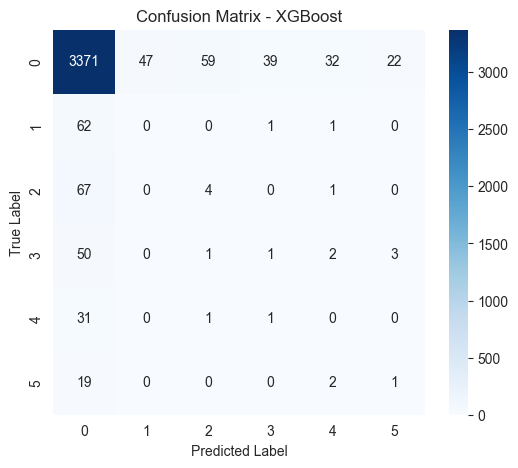

Training with 25.0% of data

Training XGBoost...


2025-04-21 20:31:38,241 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-21 20:31:39,499 INFO XGBoost-PySpark: _train_booster Training on CPUs 8]
[20:31:40] Task 0 got rank 0[20:31:40] Task 2 got rank 2            (0 + 4) / 4]

[20:31:40] Task 3 got rank 3
[20:31:40] Task 1 got rank 1
2025-04-21 20:32:06,381 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-21 20:32:10,970 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:32:12,457 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:32:14,012 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:32:15,545 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost (Data Size: 25.0%)
Accuracy: 0.8607
Precision: 0.8759
Recall: 0.8607
F1 Score: 0.8680
Training Time: 30.08 sec - Inference Latency: 0.21 sec
*Training* CPU: 49.36% | Memory: 89.43%
*Training* Disk Read: 3.45 MB | Write: 18.95 MB
*Inference* CPU: 9.30% | Memory: 89.90%
*Inference* Disk Read: 0.05 MB | Write: 0.00 MB


2025-04-21 20:32:17,147 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


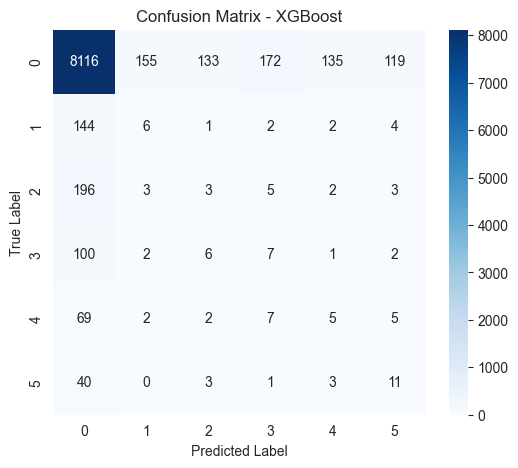

Training with 50.0% of data

Training XGBoost...


2025-04-21 20:32:47,353 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-21 20:32:49,553 INFO XGBoost-PySpark: _train_booster Training on CPUs 8]
[20:32:50] Task 2 got rank 2                                        (0 + 4) / 4]
[20:32:50] Task 1 got rank 1
[20:32:50] Task 0 got rank 0
[20:32:50] Task 3 got rank 3
2025-04-21 20:33:31,745 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-21 20:33:40,277 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:33:41,002 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:33:42,669 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:33:44,518 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost (Data Size: 50.0%)
Accuracy: 0.8617
Precision: 0.8832
Recall: 0.8617
F1 Score: 0.8720
Training Time: 46.75 sec - Inference Latency: 0.26 sec
*Training* CPU: 49.52% | Memory: 90.74%
*Training* Disk Read: 1.02 MB | Write: 37.21 MB
*Inference* CPU: 22.70% | Memory: 88.10%
*Inference* Disk Read: 2.41 MB | Write: 0.05 MB


2025-04-21 20:33:45,914 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


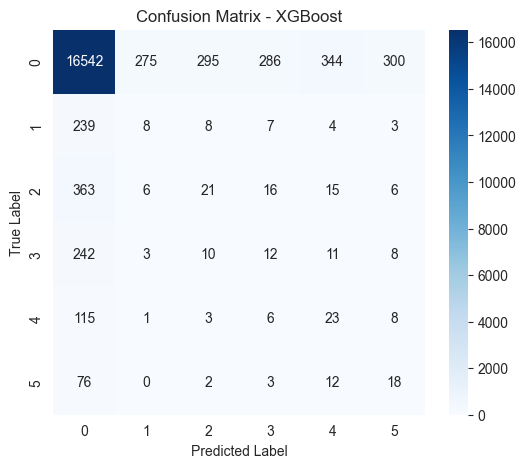

Training with 100.0% of data



Training XGBoost...


2025-04-21 20:34:47,641 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-21 20:34:51,738 INFO XGBoost-PySpark: _train_booster Training on CPUs 8]
[20:34:52] Task 0 got rank 0[20:34:52] Task 2 got rank 2[20:34:52] Task 3 got rank 3

[20:34:52] Task 1 got rank 1

2025-04-21 20:36:03,057 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-21 20:36:12,668 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:36:13,388 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:36:15,130 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-21 20:36:16,970 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost (Data Size: 100.0%)
Accuracy: 0.8385
Precision: 0.8829
Recall: 0.8385
F1 Score: 0.8593
Training Time: 81.29 sec - Inference Latency: 0.22 sec
*Training* CPU: 61.07% | Memory: 92.46%
*Training* Disk Read: 1792.89 MB | Write: 404.07 MB
*Inference* CPU: 7.10% | Memory: 91.10%
*Inference* Disk Read: 4.55 MB | Write: 0.00 MB


2025-04-21 20:36:18,624 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


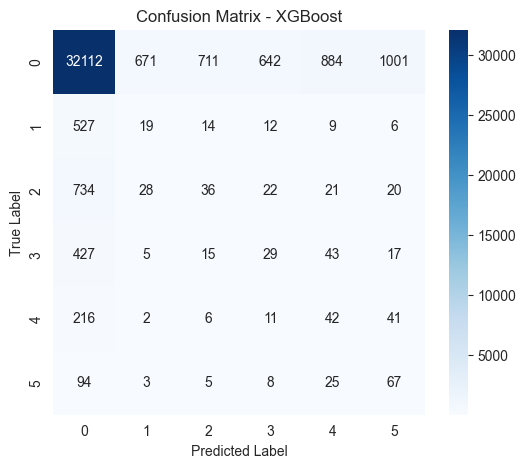

In [8]:
from pyspark.ml.linalg import Vectors
from sklearn.metrics import classification_report

# Βελτίωση της απόδοσης του Spark:
# 1) Κατανομή των δεδομένων σε 20 partitions.
# 2) Αποθήκευση των δεδομένων στη μνήμη RAM.Αν ξαναχρειαστούμε τα δεδομένα δε θα διαβαστούν από το δίσκο.
row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

final_data = final_data.repartition(20).cache()
final_data.count()  # Force materialization
print(f"final_data έχει {final_data.count()} γραμμές")

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [0.1, 0.25, 0.5, 1.0] 

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Εισαγωγή τυχαιότητας
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός δεδομένων
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # Μετατροπή δεδομένων σε Pandas DataFrame
    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή των χαρακτηριστικών από VectorUDT σε NumPy array
    X = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y = train_pandas["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Μετατροπή σε PySpark DataFrame
    resampled_df = pd.DataFrame({"scaled_features": list(X_resampled), "LabelIndex": y_resampled})

    # Μετατροπή της στήλης "scaled_features" σε VectorUDT (απαίτηση του PySpark)
    resampled_df["scaled_features"] = resampled_df["scaled_features"].apply(lambda x: Vectors.dense(x))

    # Δημιουργία PySpark DataFrame
    train_data = spark.createDataFrame(resampled_df)

# Μοντέλα
    models = {
        #"Random Forest": RandomForestClassifier(labelCol="LabelIndex", featuresCol="scaled_features", numTrees=50, maxDepth=10), 
        "XGBoost": SparkXGBClassifier(label_col="LabelIndex", features_col="scaled_features", num_workers=4, use_gpu=False, num_boost_round=100),
    }

    # Αξιολόγηση
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="weightedRecall")

    for name, model in models.items():
        print(f"\nTraining {name}...")

        monitor.start_monitoring()
        start_train = time.time()

        try:
            trained_model = model.fit(train_data)
        except Exception as e:
            print(f"Training failed: {e}")
            continue

        training_time = time.time() - start_train
        train_metrics = monitor.stop_monitoring()

        # Καθυστέρηση για σταθεροποίηση των μετρήσεων
        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        predictions = trained_model.transform(test_data)
        inference_latency = time.time() - start_infer
        infer_metrics = monitor.stop_monitoring()

        # Υπολογισμός μετρικών
        accuracy = evaluator_acc.evaluate(predictions)
        precision = evaluator_precision.evaluate(predictions)
        recall = evaluator_recall.evaluate(predictions)
        f1_score = evaluator_f1.evaluate(predictions)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

        # Confusion matrices για Linear Regression και Random Forest
        if name in ["Random Forest", "XGBoost"]:
            predictions_df = predictions.select("LabelIndex", "prediction").toPandas()
            cm = confusion_matrix(predictions_df["LabelIndex"], predictions_df["prediction"])

            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title(f"Confusion Matrix - {name}")
            plt.show()

Το dataset αποτελείται από 193637 γραμμές.
final_data έχει 193637 γραμμές

Training with 10.0% of data

Training Random Forest...

Random Forest (Data Size: 10.0%)
Accuracy: 0.8201
Precision: 0.8700
Recall: 0.8201
F1 Score: 0.8442
Training Time: 74.03 sec - Inference Latency: 0.15 sec
*Training* CPU: 23.53% | Memory: 89.89%
*Training* Disk Read: 76.66 MB | Write: 53.63 MB
*Inference* CPU: 37.50% | Memory: 90.00%
*Inference* Disk Read: 2.00 MB | Write: 0.04 MB


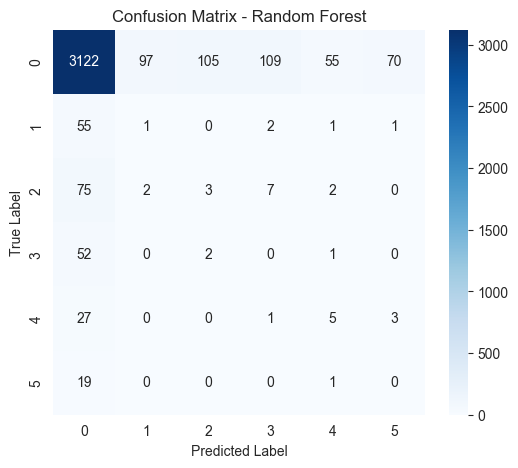

In [12]:
# ------- RF με class weights και βελτιωμένες παραμέτρους -------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import time

# Καταμέτρηση των γραμμών
row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

# Repartition και cache
final_data = final_data.repartition(20).cache()
final_data.count()
print(f"final_data έχει {final_data.count()} γραμμές")

# Ενεργοποίηση resource monitor
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων
sizes = [0.1]

for size in sizes:
    print(f"\nTraining with {size * 100}% of data")

    # Υποδειγματική δειγματοληψία
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός train/test
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # PySpark -> Pandas
    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()
    test_pandas = test_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή σε NumPy arrays
    X_train = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_train = train_pandas["LabelIndex"].values
    X_test = np.array(test_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_test = test_pandas["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Ορισμός μοντέλου Scikit-learn με class_weight
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        class_weight='balanced',
        random_state=42
    )

    print(f"\nTraining Random Forest...")

    monitor.start_monitoring()
    start_train = time.time()

    try:
        model.fit(X_resampled, y_resampled)
    except Exception as e:
        print(f"Training failed: {e}")
        continue

    training_time = time.time() - start_train
    train_metrics = monitor.stop_monitoring()

    time.sleep(3)

    start_infer = time.time()
    monitor.start_monitoring()

    y_pred = model.predict(X_test)

    inference_latency = time.time() - start_infer
    infer_metrics = monitor.stop_monitoring()

    # Υπολογισμός μετρικών
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    # Εκτύπωση αποτελεσμάτων
    print(f"\nRandom Forest (Data Size: {size * 100}%)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
    print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
    print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
    print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
    print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Random Forest")
    plt.show()


Training GridSearchCV for KNN (with SMOTE)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best KNN Parameters:
{'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

Final Evaluation on Test Set:
Accuracy: 0.5846
Precision: 0.8780
Recall: 0.5846
F1 Score: 0.6970
Training Time: 724.99 sec


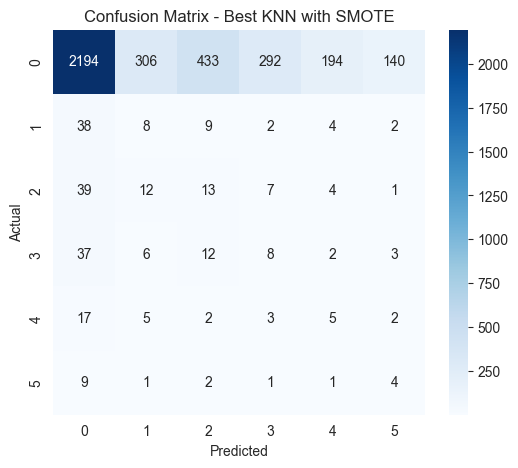

In [14]:
# GridSearchCV

from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# UDF για μετατροπή Vector σε λίστα
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Δειγματοληψία
final_data = final_data.repartition(20).cache()
size = 0.1
sub_sampled_data = final_data.sample(fraction=size, seed=42)
train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

# Μετατροπή σε Pandas
train_pd = train_data.select(
    vector_to_array_udf("scaled_features").alias("features"), "LabelIndex"
).dropna().toPandas()

test_pd = test_data.select(
    vector_to_array_udf("scaled_features").alias("features"), "LabelIndex"
).dropna().toPandas()

X_train = np.vstack(train_pd["features"].values)
y_train = train_pd["LabelIndex"].values
X_test = np.vstack(test_pd["features"].values)
y_test = test_pd["LabelIndex"].values

# --- Εφαρμογή SMOTE ---
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Ορισμός μοντέλου
knn = KNeighborsClassifier()

# Ορισμός πλέγματος υπερπαραμέτρων
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['distance', 'uniform'],
    'metric': ['euclidean', 'manhattan'],
    'leaf_size': [10, 20]
}

# GridSearch με F1 score
scoring = 'f1_weighted'

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scoring,
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Εκπαίδευση με GridSearchCV
print("Training GridSearchCV for KNN (with SMOTE)...")
start_time = time.time()
grid.fit(X_resampled, y_resampled)
train_duration = time.time() - start_time

# Καλύτερο μοντέλο
best_knn = grid.best_estimator_
print("\nBest KNN Parameters:")
print(grid.best_params_)

# Προβλέψεις
y_pred = best_knn.predict(X_test)

# Μετρικές Αξιολόγησης
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Training Time: {train_duration:.2f} sec")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best KNN with SMOTE")
plt.show()



Το dataset αποτελείται από 193637 γραμμές.


final_data έχει 193637 γραμμές

Training with 10.0% of data

Training KNN...

KNN (Data Size: 10.0%)
Accuracy: 0.5726
Precision: 0.8747
Recall: 0.5726
F1 Score: 0.6880
Training Time: 0.01 sec - Inference Latency: 1.26 sec
*Training* CPU: 68.40% | Memory: 88.20%
*Training* Disk Read: 0.05 MB | Write: 0.46 MB
*Inference* CPU: 31.50% | Memory: 88.20%
*Inference* Disk Read: 0.02 MB | Write: 0.04 MB

Training with 25.0% of data

Training KNN...

KNN (Data Size: 25.0%)
Accuracy: 0.5963
Precision: 0.8754
Recall: 0.5963
F1 Score: 0.7053
Training Time: 0.02 sec - Inference Latency: 6.52 sec
*Training* CPU: 5.50% | Memory: 88.60%
*Training* Disk Read: 0.00 MB | Write: 0.00 MB
*Inference* CPU: 43.87% | Memory: 88.60%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB

Training with 50.0% of data

Training KNN...

KNN (Data Size: 50.0%)
Accuracy: 0.6060
Precision: 0.8801
Recall: 0.6060
F1 Score: 0.7133
Training Time: 0.05 sec - Inference Latency: 24.67 sec
*Training* CPU: 18.00% | Memory: 88.50%
*Tra

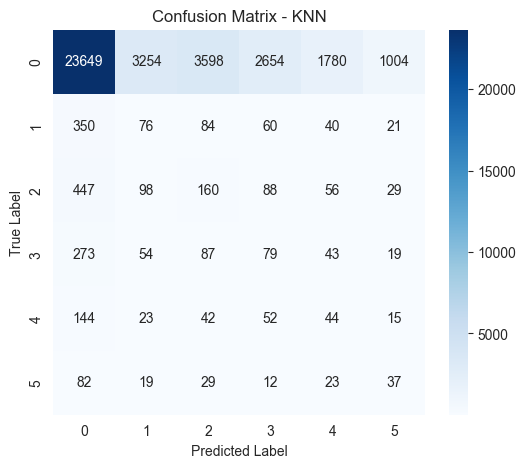

In [13]:
# Ξεχωριστό cell για το μοντέλο KNN, καθώς είναι διαφορετική η όλη διαδικασία για το συγκεκριμένο μοντέλο σε αντίθεση με τα προηγούμενα.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

final_data = final_data.repartition(20).cache()
final_data.count()
print(f"final_data έχει {final_data.count()} γραμμές")

monitor = ResourceMonitorListener()

sizes = [0.1, 0.25, 0.5, 1.0] 

for size in sizes:
    print(f"\nTraining with {size * 100}% of data")

    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()
    test_pandas = test_data.select("scaled_features", "LabelIndex").toPandas()

    X_train = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_train = train_pandas["LabelIndex"].values

    X_test = np.array(test_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_test = test_pandas["LabelIndex"].values

    # SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Μοντέλα
    models = {
        "KNN": KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='distance', leaf_size=10) 
    }

    for name, model in models.items():
        print(f"\nTraining {name}...")

        monitor.start_monitoring()
        start_train = time.time()

        try:
            model.fit(X_resampled, y_resampled)
        except Exception as e:
            print(f"Training failed: {e}")
            continue

        training_time = time.time() - start_train
        train_metrics = monitor.stop_monitoring()

        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        y_pred = model.predict(X_test)
        inference_latency = time.time() - start_infer
        infer_metrics = monitor.stop_monitoring()

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

        if size==1:
            predictions_df = pd.DataFrame({"LabelIndex": y_test, "prediction": y_pred})
            cm = confusion_matrix(predictions_df["LabelIndex"], predictions_df["prediction"])

            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title(f"Confusion Matrix - {name}")
            plt.show()


Το dataset αποτελείται από 193637 γραμμές.
final_data έχει 193637 γραμμές
Training with 10.0% of data

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 86814, number of used features: 20
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM (Data Size: 10.0%)
Accuracy: 0.8423
Precision: 0.8693
Recall: 0.8423
F1 Score: 0.8555
Training Time: 3.84 sec - Inference Latency: 0.11 sec
*Training* CPU: 91.00% | Memory: 85.30%
*Training* Disk Read: 4.54 MB | Write: 2.37 MB
*Inference* CPU: 21.

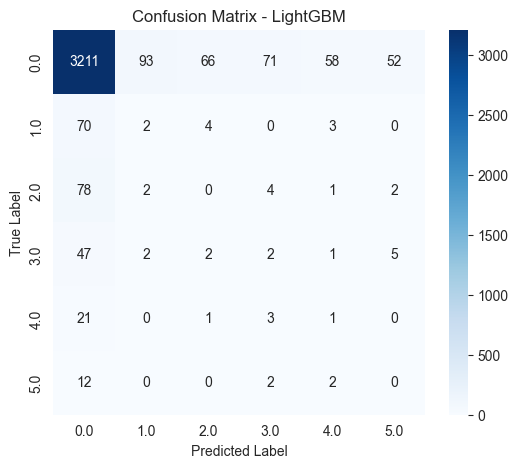

Training with 25.0% of data

Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 218760, number of used features: 20
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM (Data Size: 25.0%)
Accuracy: 0.8376
Precision: 0.8728
Recall: 0.8376
F1 Score: 0.8544
Training Time: 8.27 sec - Inference Latency: 0.12 sec
*Training* CPU: 87.77% | Memory: 85.70%
*Training* Disk Read: 0.41 MB | Write: 0.09 MB
*Inference* CPU: 13.60% | Mem

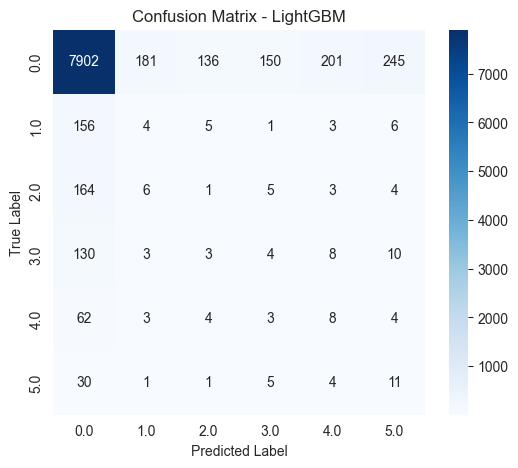

Training with 50.0% of data

Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 436356, number of used features: 20
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM (Data Size: 50.0%)
Accuracy: 0.8278
Precision: 0.8798
Recall: 0.8278
F1 Score: 0.8520
Training Time: 16.73 sec - Inference Latency: 0.27 sec
*Training* CPU: 93.34% | Memory: 86.79%
*Training* Disk Read: 0.11 MB | Write: 0.11 MB
*Inference* CPU: 24.30% | Me

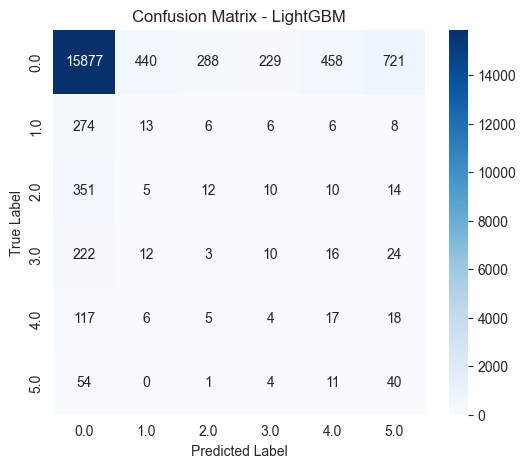

Training with 100.0% of data

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 868620, number of used features: 20
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM (Data Size: 100.0%)
Accuracy: 0.8055
Precision: 0.8826
Recall: 0.8055
F1 Score: 0.8408
Training Time: 46.21 sec - Inference Latency: 0.40 sec
*Training* CPU: 93.90% | Memory: 89.94%
*Training* Disk Read: 33.27 MB | Write: 0.55 MB
*Inference* CPU: 39.50% | Memory: 90.10%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


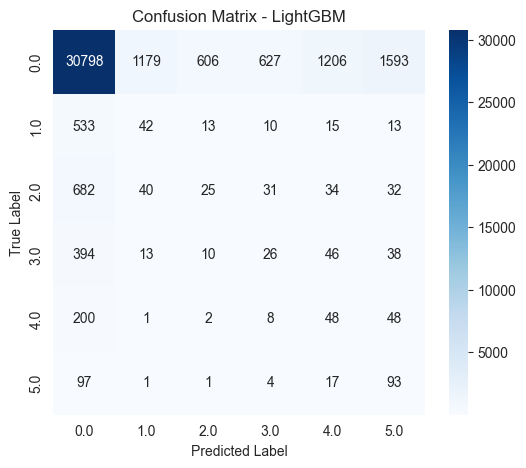

In [9]:
# Ξεχωριστό cell για το μοντέλο Light GBM, καθώς είναι διαφορετική η όλη διαδικασία για το συγκεκριμένο μοντέλο σε αντίθεση με τα προηγούμενα.

import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from pyspark.ml.linalg import Vectors
from sklearn.metrics import precision_score, recall_score, f1_score

row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

final_data = final_data.repartition(20).cache()
final_data.count()  # Force materialization
print(f"final_data έχει {final_data.count()} γραμμές")

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [0.1, 0.25, 0.5, 1.0]  

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Εισαγωγή τυχαιότητας
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός δεδομένων
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # Μετατροπή δεδομένων σε Pandas DataFrame
    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή των χαρακτηριστικών από VectorUDT σε NumPy array
    X = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y = train_pandas["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Μετατροπή σε PySpark DataFrame
    resampled_df = pd.DataFrame({"scaled_features": list(X_resampled), "LabelIndex": y_resampled})

    # Μετατροπή της στήλης "scaled_features" σε VectorUDT (απαίτηση του PySpark)
    resampled_df["scaled_features"] = resampled_df["scaled_features"].apply(lambda x: Vectors.dense(x))

    # Δημιουργία PySpark DataFrame
    train_data = spark.createDataFrame(resampled_df)

    # Ετοιμασία των δεδομένων για LightGBM (σε NumPy arrays)
    X_train = np.array(resampled_df['scaled_features'].apply(lambda x: np.array(x.toArray())).tolist())
    y_train = np.array(resampled_df['LabelIndex'].values)

    # Δημιουργία LightGBM Dataset
    lgb_train = lgb.Dataset(X_train, label=y_train)

    # Ορισμός παραμέτρων για το LightGBM
    params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),  # multi-class ταξινόμηση
        'metric': 'multi_logloss',        # multi-class συνάρτηση κόστους
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    # Εκπαίδευση του μοντέλου LightGBM
    print("\nTraining LightGBM model...")
    monitor.start_monitoring()
    start_train = time.time()

    # Εκπαίδευση LightGBM
    try:
        gbm = lgb.train(params, lgb_train, 100)
    except Exception as e:
        print(f"Training failed: {e}")
        continue

    training_time = time.time() - start_train
    train_metrics = monitor.stop_monitoring()

    # Καθυστέρηση για σταθεροποίηση των μετρήσεων
    time.sleep(3)

    # Πρόβλεψη με το μοντέλο
    X_test = np.array(test_data.select("scaled_features").toPandas()['scaled_features'].apply(lambda x: np.array(x.toArray())).tolist())
    y_test = np.array(test_data.select("LabelIndex").toPandas()['LabelIndex'])

    start_infer = time.time()
    monitor.start_monitoring()

    y_pred = gbm.predict(X_test)
    inference_latency = time.time() - start_infer
    infer_metrics = monitor.stop_monitoring()

    # Επιλογή της κατηγορίας με τη μέγιστη πιθανότητα
    y_pred_class = np.argmax(y_pred, axis=1)

    # Υπολογισμός μετρικών
    accuracy = np.mean(y_pred_class == y_test)
    precision = precision_score(y_test, y_pred_class, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred_class, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred_class, average="weighted", zero_division=0)

    # Εκτύπωση αποτελεσμάτων
    print(f"\nLightGBM (Data Size: {size * 100}%)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
    print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
    print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
    print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
    print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

    # Confusion matrices
    cm = confusion_matrix(y_test, y_pred_class)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - LightGBM")
    plt.show()


Το dataset αποτελείται από 193637 γραμμές.
final_data έχει 193637 γραμμές

Training with 10.0% of data

Training Random Forest...

Final Evaluation on Test Set:
Accuracy: 0.8290
Precision: 0.8790
Recall: 0.8290
F1 Score: 0.8529
Training Time: 73.20 sec
Inference Time: 0.12 sec

Feature Importance:


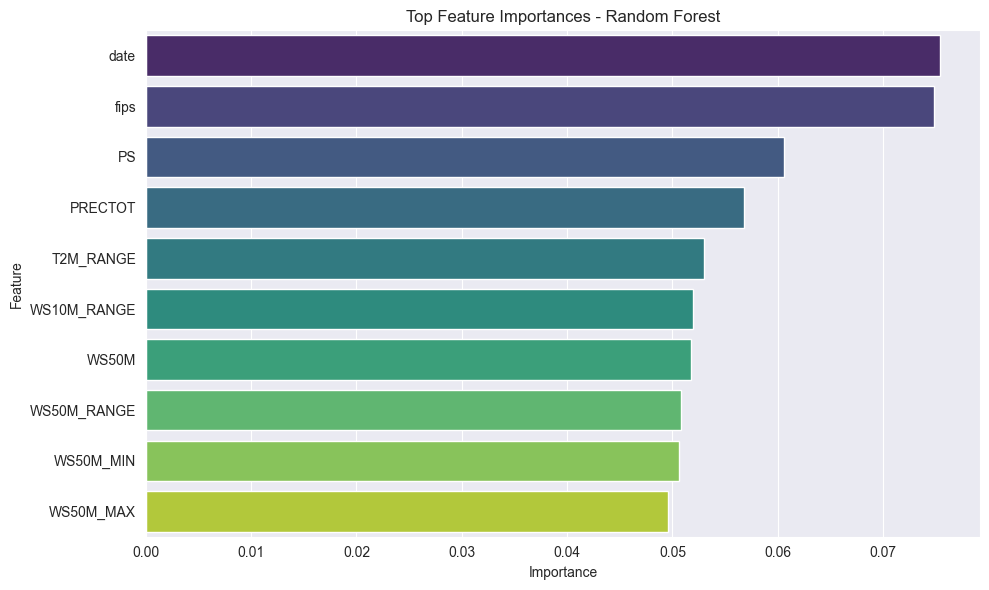

In [16]:
# Feature Importance

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, ArrayType
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# UDF για μετατροπή vector σε array
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Cache δεδομένων
row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

final_data = final_data.repartition(20).cache()
final_data.count()
print(f"final_data έχει {final_data.count()} γραμμές")

# Ενεργοποίηση resource monitor (αν έχεις δικό σου listener)
monitor = ResourceMonitorListener()

# Ποσοστά δεδομένων για πειράματα
sizes = [0.1]

for size in sizes:
    print(f"\nTraining with {size * 100}% of data")

    # Δειγματοληψία
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός σε train/test
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # PySpark -> Pandas
    train_pd = train_data.select("scaled_features", "LabelIndex").toPandas()
    test_pd = test_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή σε NumPy πίνακες
    X_train = np.array(train_pd["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_train = train_pd["LabelIndex"].values
    X_test = np.array(test_pd["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_test = test_pd["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Ορισμός μοντέλου
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        class_weight='balanced',
        random_state=42
    )

    print("\nTraining Random Forest...")
    monitor.start_monitoring()
    start_train = time.time()

    try:
        model.fit(X_resampled, y_resampled)
    except Exception as e:
        print(f"Training failed: {e}")
        continue

    training_time = time.time() - start_train
    train_metrics = monitor.stop_monitoring()

    # Inference
    time.sleep(3)
    start_infer = time.time()
    monitor.start_monitoring()

    y_pred = model.predict(X_test)

    inference_latency = time.time() - start_infer
    infer_metrics = monitor.stop_monitoring()

    # Αξιολόγηση
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    print(f"\nFinal Evaluation on Test Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f} sec")
    print(f"Inference Time: {inference_latency:.2f} sec")

    feature_names = assembler.getInputCols()

    # Feature Importance
    print("\nFeature Importance:")
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_k = 10  # Top 10 features
    
    # Top feature names
    top_features = [feature_names[i] for i in indices[:top_k]]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=importances[indices][:top_k],
        y=top_features,
        palette="viridis"
    )
    plt.title("Top Feature Importances - Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


In [7]:
# Feature Selection

# Στήλη score:Μετατροπή των NULL τιμών σε 0.0
full_data = full_data.withColumn("score", when(col("score").isNull(), 0.0).otherwise(col("score")))

# Multi-class Classification: Μετατροπή του score σε κατηγορίες(None, D0-D4)
full_data = full_data.withColumn(
    "Label",
    when(col("score") == 0.0, "None")
    .when((col("score") > 0.0) & (col("score") < 1.0), "D0")
    .when((col("score") >= 1.0) & (col("score") < 2.0), "D1")
    .when((col("score") >= 2.0) & (col("score") < 3.0), "D2")
    .when((col("score") >= 3.0) & (col("score") < 4.0), "D3")
    .when((col("score") >= 4.0) & (col("score") <= 5.0), "D4")
)

#Μετατροπή datatype ημερομηνίας:date->int
full_data = full_data.withColumn("date", date_format(col("date"), "yyyyMMdd").cast("int"))

labels_order = ["None", "D0", "D1", "D2", "D3", "D4"]  # Ορίζουμε ότι None=0, D0=1, D1=2, ...

# Μετατροπή της κατηγορικής μεταβλητής Label σε αριθμητική(0,1,2,3,4,5)
indexer = StringIndexerModel.from_labels(labels_order, inputCol="Label", outputCol="LabelIndex")

if 'LabelIndex' in full_data.columns:
    full_data = full_data.drop('LabelIndex')

full_data = indexer.transform(full_data)

#reduced_cols = ["date","fips","T2M_MAX","PRECTOT","WS50M_RANGE","WS10M_RANGE","PS","T2M_RANGE" ]
reduced_cols = ["date","fips","PS","PRECTOT","T2M_RANGE","WS10M_RANGE","WS50M"]

assembler = VectorAssembler(inputCols=reduced_cols, outputCol="features")

# Z-score κανονικοποίηση
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

pipeline = Pipeline(stages=[
    assembler,
    scaler
])

# Fit και Transform
pipeline_model = pipeline.fit(full_data)
full_data = pipeline_model.transform(full_data)

# Τελική επιλογή στηλών
final_data = full_data.select("scaled_features", "LabelIndex")

Το dataset αποτελείται από 193637 γραμμές.
final_data έχει 193637 γραμμές

Training with 100.0% of data

Training Random Forest...

Random Forest (Data Size: 100.0%)
Accuracy: 0.7181
Precision: 0.8830
Recall: 0.7181
F1 Score: 0.7893
Training Time: 486.40 sec - Inference Latency: 0.60 sec
*Training* CPU: 16.55% | Memory: 79.71%
*Training* Disk Read: 1588.68 MB | Write: 146.52 MB
*Inference* CPU: 8.30% | Memory: 81.10%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


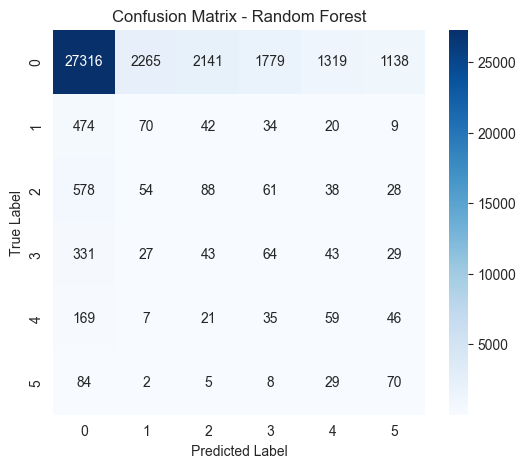

In [9]:
# Ανάλυση μετά το Feature Selection

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import time

# Καταμέτρηση των γραμμών
row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

# Repartition και cache
final_data = final_data.repartition(20).cache()
final_data.count()
print(f"final_data έχει {final_data.count()} γραμμές")

# Ενεργοποίηση resource monitor
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων
sizes = [1.0]

for size in sizes:
    print(f"\nTraining with {size * 100}% of data")

    # Υποδειγματική δειγματοληψία
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός train/test
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # PySpark -> Pandas
    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()
    test_pandas = test_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή σε NumPy arrays
    X_train = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_train = train_pandas["LabelIndex"].values
    X_test = np.array(test_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_test = test_pandas["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Ορισμός μοντέλου Scikit-learn με class_weight
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        class_weight='balanced',
        random_state=42
    )

    print(f"\nTraining Random Forest...")

    monitor.start_monitoring()
    start_train = time.time()

    try:
        model.fit(X_resampled, y_resampled)
    except Exception as e:
        print(f"Training failed: {e}")
        continue

    training_time = time.time() - start_train
    train_metrics = monitor.stop_monitoring()

    time.sleep(3)

    start_infer = time.time()
    monitor.start_monitoring()

    y_pred = model.predict(X_test)

    inference_latency = time.time() - start_infer
    infer_metrics = monitor.stop_monitoring()

    # Υπολογισμός μετρικών
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    # Εκτύπωση αποτελεσμάτων
    print(f"\nRandom Forest (Data Size: {size * 100}%)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
    print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
    print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
    print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
    print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Random Forest")
    plt.show()

In [8]:
# Αλλαγή στις παραμέτρους του μοντέλου RF

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import time

# Καταμέτρηση των γραμμών
row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

# Repartition και cache
final_data = final_data.repartition(20).cache()
final_data.count()
print(f"final_data έχει {final_data.count()} γραμμές")

# Ενεργοποίηση resource monitor
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων
sizes = [0.1]

for size in sizes:
    print(f"\nTraining with {size * 100}% of data")

    # Υποδειγματική δειγματοληψία
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός train/test
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # PySpark -> Pandas
    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()
    test_pandas = test_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή σε NumPy arrays
    X_train = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_train = train_pandas["LabelIndex"].values
    X_test = np.array(test_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_test = test_pandas["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Ορισμός μοντέλου Scikit-learn με class_weight
    model = RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    )

    print(f"\nTraining Random Forest...")

    monitor.start_monitoring()
    start_train = time.time()

    try:
        model.fit(X_resampled, y_resampled)
    except Exception as e:
        print(f"Training failed: {e}")
        continue

    training_time = time.time() - start_train
    train_metrics = monitor.stop_monitoring()

    time.sleep(3)

    start_infer = time.time()
    monitor.start_monitoring()

    y_pred = model.predict(X_test)

    inference_latency = time.time() - start_infer
    infer_metrics = monitor.stop_monitoring()

    # Υπολογισμός μετρικών
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    # Εκτύπωση αποτελεσμάτων
    print(f"\nRandom Forest (Data Size: {size * 100}%)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
    print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
    print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
    print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
    print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

Το dataset αποτελείται από 193637 γραμμές.


final_data έχει 193637 γραμμές

Training with 10.0% of data

Training Random Forest...

Random Forest (Data Size: 10.0%)
Accuracy: 0.5770
Precision: 0.8808
Recall: 0.5770
F1 Score: 0.6937
Training Time: 29.14 sec - Inference Latency: 0.04 sec
*Training* CPU: 16.97% | Memory: 75.46%
*Training* Disk Read: 23.82 MB | Write: 24.25 MB
*Inference* CPU: 2.00% | Memory: 75.50%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


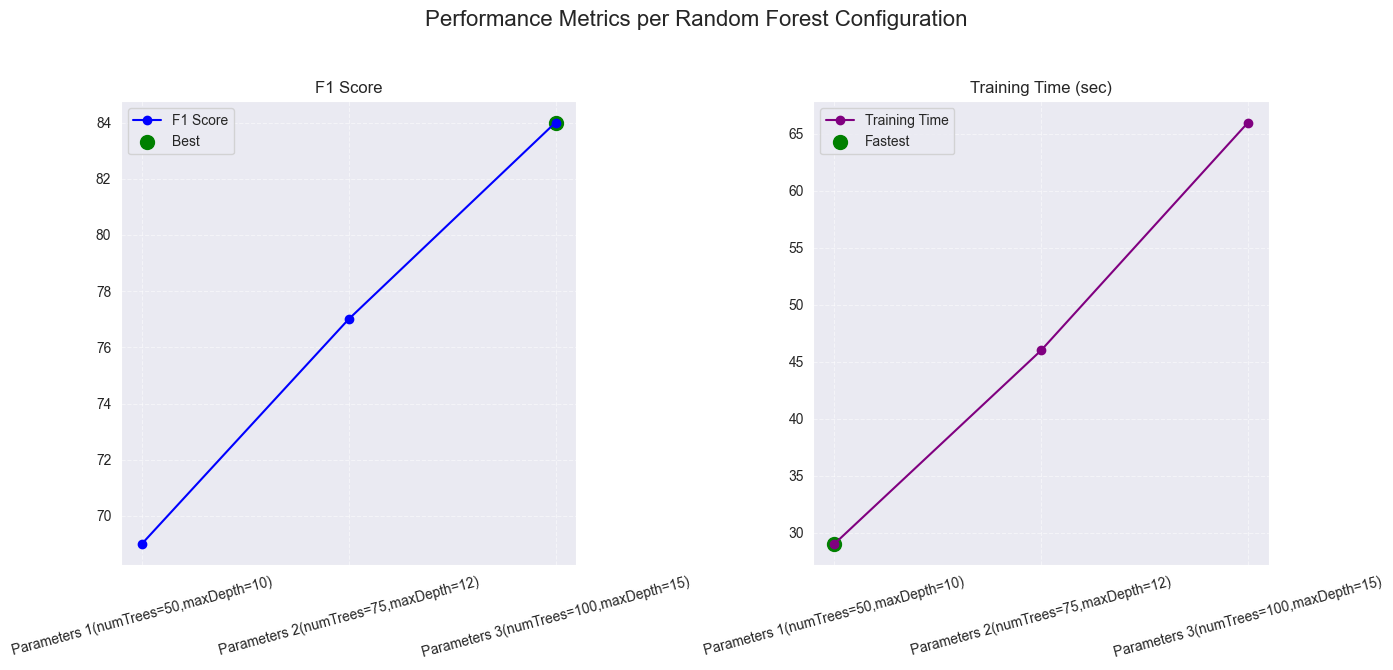

In [14]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['Parameters 1(numTrees=50,maxDepth=10)',
           'Parameters 2(numTrees=75,maxDepth=12)',
           'Parameters 3(numTrees=100,maxDepth=15)']
x = np.arange(len(methods))

# Μετρικές
f1_score = [69, 77, 84]
training_time = [29, 46, 66]

# Δημιουργία figure με 4 υπο-διαγράμματα (2x2 grid)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Performance Metrics per Random Forest Configuration", fontsize=16)

# --------- 1. F1 Score ---------
best_f1_idx = np.argmax(f1_score)
axs[0].plot(x, f1_score, marker='o', linestyle='-', color='blue', label="F1 Score")
axs[0].scatter(best_f1_idx, f1_score[best_f1_idx], color='green', s=100, label="Best")
axs[0].set_title("F1 Score")
axs[0].set_xticks(x)
axs[0].set_xticklabels(methods, rotation=15)
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].legend()

# --------- 2. Training Time ---------
best_time_idx = np.argmin(training_time)
axs[1].plot(x, training_time, marker='o', linestyle='-', color='purple', label="Training Time")
axs[1].scatter(best_time_idx, training_time[best_time_idx], color='green', s=100, label="Fastest")
axs[1].set_title("Training Time (sec)")
axs[1].set_xticks(x)
axs[1].set_xticklabels(methods, rotation=15)
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Το dataset αποτελείται από 193637 γραμμές.
final_data έχει 193637 γραμμές

Training with 10.0% of data

Training Random Forest...

Random Forest (Data Size: 10.0%)
Accuracy: 0.9322
Precision: 0.8689
Recall: 0.9322
F1 Score: 0.8994
Training Time: 9.23 sec - Inference Latency: 0.10 sec
*Training* CPU: 37.66% | Memory: 93.40%
*Training* Disk Read: 1.00 MB | Write: 0.41 MB
*Inference* CPU: 3.10% | Memory: 93.40%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


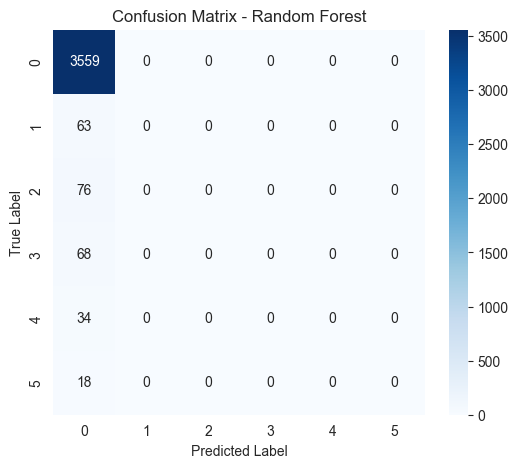

In [14]:
# Ανάλυση χωρίς SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import time

# Καταμέτρηση των γραμμών
row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

# Repartition και cache
final_data = final_data.repartition(20).cache()
final_data.count()
print(f"final_data έχει {final_data.count()} γραμμές")

monitor = ResourceMonitorListener()
sizes = [0.1]

for size in sizes:
    print(f"\nTraining with {size * 100}% of data")

    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()
    test_pandas = test_data.select("scaled_features", "LabelIndex").toPandas()

    X_train = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_train = train_pandas["LabelIndex"].values
    X_test = np.array(test_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_test = test_pandas["LabelIndex"].values

    # ΧΩΡΙΣ SMOTE
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        class_weight='balanced',
        random_state=42
    )

    print(f"\nTraining Random Forest...")

    monitor.start_monitoring()
    start_train = time.time()

    try:
        model.fit(X_train, y_train)  # <<< Χρήση X_train και y_train κατευθείαν
    except Exception as e:
        print(f"Training failed: {e}")
        continue

    training_time = time.time() - start_train
    train_metrics = monitor.stop_monitoring()

    time.sleep(3)

    start_infer = time.time()
    monitor.start_monitoring()

    y_pred = model.predict(X_test)

    inference_latency = time.time() - start_infer
    infer_metrics = monitor.stop_monitoring()

    # Υπολογισμός μετρικών
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    # Εκτύπωση αποτελεσμάτων
    print(f"\nRandom Forest (Data Size: {size * 100}%)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
    print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
    print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
    print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
    print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Random Forest")
    plt.show()


In [9]:
# Ανάλυση χωρίς partitioning και caching

from pyspark.ml.linalg import Vectors

row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

final_data = final_data
final_data.count()  # Force materialization
print(f"final_data έχει {final_data.count()} γραμμές")

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [0.99] 

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Εισαγωγή τυχαιότητας
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός δεδομένων
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # Μετατροπή δεδομένων σε Pandas DataFrame
    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή των χαρακτηριστικών από VectorUDT σε NumPy array
    X = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y = train_pandas["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Μετατροπή σε PySpark DataFrame
    resampled_df = pd.DataFrame({"scaled_features": list(X_resampled), "LabelIndex": y_resampled})

    # Μετατροπή της στήλης "scaled_features" σε VectorUDT (απαίτηση του PySpark)
    resampled_df["scaled_features"] = resampled_df["scaled_features"].apply(lambda x: Vectors.dense(x))

    # Δημιουργία PySpark DataFrame
    train_data = spark.createDataFrame(resampled_df)

    # Μοντέλα
    models = {
        "XGBoost": SparkXGBClassifier(label_col="LabelIndex", features_col="scaled_features", num_workers=4, use_gpu=False, num_boost_round=100),
    }

    # Αξιολόγηση
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="weightedRecall")

    for name, model in models.items():
        print(f"\nTraining {name}...")

        monitor.start_monitoring()
        start_train = time.time()

        try:
            trained_model = model.fit(train_data)
        except Exception as e:
            print(f"Training failed: {e}")
            continue

        training_time = time.time() - start_train
        train_metrics = monitor.stop_monitoring()

        # Καθυστέρηση για σταθεροποίηση των μετρήσεων
        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        predictions = trained_model.transform(test_data)
        inference_latency = time.time() - start_infer
        infer_metrics = monitor.stop_monitoring()

        # Υπολογισμός μετρικών
        accuracy = evaluator_acc.evaluate(predictions)
        precision = evaluator_precision.evaluate(predictions)
        recall = evaluator_recall.evaluate(predictions)
        f1_score = evaluator_f1.evaluate(predictions)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

Το dataset αποτελείται από 193637 γραμμές.


final_data έχει 193637 γραμμές
Training with 99.0% of data



Training XGBoost...


2025-04-14 12:05:45,937 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-14 12:05:55,456 INFO XGBoost-PySpark: _train_booster Training on CPUs 4]
[12:05:56] Task 2 got rank 2
[12:05:56] Task 1 got rank 1
[12:05:56] Task 0 got rank 0
[12:05:56] Task 3 got rank 3
2025-04-14 12:07:10,082 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-14 12:07:28,029 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-14 12:07:57,320 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-14 12:08:26,448 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-14 12:08:54,969 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost (Data Size: 99.0%)
Accuracy: 0.8301
Precision: 0.8837
Recall: 0.8301
F1 Score: 0.8552
Training Time: 92.41 sec - Inference Latency: 0.32 sec
*Training* CPU: 52.60% | Memory: 90.76%
*Training* Disk Read: 308.51 MB | Write: 267.67 MB
*Inference* CPU: 25.10% | Memory: 91.70%
*Inference* Disk Read: 0.22 MB | Write: 0.00 MB


In [8]:
# Ανάλυση μόνο με caching

from pyspark.ml.linalg import Vectors

row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

final_data = final_data.cache()
final_data.count()  # Force materialization
print(f"final_data έχει {final_data.count()} γραμμές")

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [0.99]

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Εισαγωγή τυχαιότητας
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός δεδομένων
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # Μετατροπή δεδομένων σε Pandas DataFrame
    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή των χαρακτηριστικών από VectorUDT σε NumPy array
    X = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y = train_pandas["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Μετατροπή σε PySpark DataFrame
    resampled_df = pd.DataFrame({"scaled_features": list(X_resampled), "LabelIndex": y_resampled})

    # Μετατροπή της στήλης "scaled_features" σε VectorUDT (απαίτηση του PySpark)
    resampled_df["scaled_features"] = resampled_df["scaled_features"].apply(lambda x: Vectors.dense(x))

    # Δημιουργία PySpark DataFrame
    train_data = spark.createDataFrame(resampled_df)

    # Μοντέλα
    models = {
        "XGBoost": SparkXGBClassifier(label_col="LabelIndex", features_col="scaled_features", num_workers=4, use_gpu=False, num_boost_round=100),
    }

    # Αξιολόγηση
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="weightedRecall")

    for name, model in models.items():
        print(f"\nTraining {name}...")

        monitor.start_monitoring()
        start_train = time.time()

        try:
            trained_model = model.fit(train_data)
        except Exception as e:
            print(f"Training failed: {e}")
            continue

        training_time = time.time() - start_train
        train_metrics = monitor.stop_monitoring()

        # Καθυστέρηση για σταθεροποίηση των μετρήσεων
        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        predictions = trained_model.transform(test_data)
        inference_latency = time.time() - start_infer
        infer_metrics = monitor.stop_monitoring()

        # Υπολογισμός μετρικών
        accuracy = evaluator_acc.evaluate(predictions)
        precision = evaluator_precision.evaluate(predictions)
        recall = evaluator_recall.evaluate(predictions)
        f1_score = evaluator_f1.evaluate(predictions)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

Το dataset αποτελείται από 193637 γραμμές.


final_data έχει 193637 γραμμές
Training with 99.0% of data



Training XGBoost...


2025-04-14 12:28:59,903 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-14 12:29:09,567 INFO XGBoost-PySpark: _train_booster Training on CPUs 4]
[12:29:10] Task 2 got rank 2
[12:29:10] Task 1 got rank 1
[12:29:10] Task 0 got rank 0[12:29:10] Task 3 got rank 3

2025-04-14 12:30:21,837 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-14 12:30:27,606 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-14 12:30:32,198 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-14 12:30:34,049 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-14 12:30:35,843 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost (Data Size: 99.0%)
Accuracy: 0.8301
Precision: 0.8837
Recall: 0.8301
F1 Score: 0.8552
Training Time: 90.89 sec - Inference Latency: 0.30 sec
*Training* CPU: 54.50% | Memory: 92.75%
*Training* Disk Read: 214.90 MB | Write: 278.25 MB
*Inference* CPU: 26.00% | Memory: 93.90%
*Inference* Disk Read: 0.09 MB | Write: 0.00 MB


In [8]:
# Ανάλυση μόνο με partitioning

from pyspark.ml.linalg import Vectors

row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

final_data = final_data.repartition(20)
final_data.count()  # Force materialization
print(f"final_data έχει {final_data.count()} γραμμές")

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [0.99]

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Εισαγωγή τυχαιότητας
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός δεδομένων
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # Μετατροπή δεδομένων σε Pandas DataFrame
    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή των χαρακτηριστικών από VectorUDT σε NumPy array
    X = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y = train_pandas["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Μετατροπή σε PySpark DataFrame
    resampled_df = pd.DataFrame({"scaled_features": list(X_resampled), "LabelIndex": y_resampled})

    # Μετατροπή της στήλης "scaled_features" σε VectorUDT (απαίτηση του PySpark)
    resampled_df["scaled_features"] = resampled_df["scaled_features"].apply(lambda x: Vectors.dense(x))

    # Δημιουργία PySpark DataFrame
    train_data = spark.createDataFrame(resampled_df)

    # Μοντέλα
    models = {
        "XGBoost": SparkXGBClassifier(label_col="LabelIndex", features_col="scaled_features", num_workers=4, use_gpu=False, num_boost_round=100),
    }

    # Αξιολόγηση
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="weightedRecall")

    for name, model in models.items():
        print(f"\nTraining {name}...")

        monitor.start_monitoring()
        start_train = time.time()

        try:
            trained_model = model.fit(train_data)
        except Exception as e:
            print(f"Training failed: {e}")
            continue

        training_time = time.time() - start_train
        train_metrics = monitor.stop_monitoring()

        # Καθυστέρηση για σταθεροποίηση των μετρήσεων
        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        predictions = trained_model.transform(test_data)
        inference_latency = time.time() - start_infer
        infer_metrics = monitor.stop_monitoring()

        # Υπολογισμός μετρικών
        accuracy = evaluator_acc.evaluate(predictions)
        precision = evaluator_precision.evaluate(predictions)
        recall = evaluator_recall.evaluate(predictions)
        f1_score = evaluator_f1.evaluate(predictions)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

Το dataset αποτελείται από 193637 γραμμές.


final_data έχει 193637 γραμμές
Training with 99.0% of data



Training XGBoost...


2025-04-14 12:41:27,872 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-14 12:41:37,570 INFO XGBoost-PySpark: _train_booster Training on CPUs 4]
[12:41:38] Task 2 got rank 2
[12:41:38] Task 1 got rank 1
[12:41:38] Task 0 got rank 0[12:41:38] Task 3 got rank 3

2025-04-14 12:42:46,685 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-14 12:43:26,319 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-14 12:43:53,438 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-14 12:44:22,725 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-14 12:44:51,288 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost (Data Size: 99.0%)
Accuracy: 0.8398
Precision: 0.8780
Recall: 0.8398
F1 Score: 0.8577
Training Time: 86.32 sec - Inference Latency: 0.31 sec
*Training* CPU: 53.68% | Memory: 91.90%
*Training* Disk Read: 283.10 MB | Write: 133.79 MB
*Inference* CPU: 21.50% | Memory: 92.70%
*Inference* Disk Read: 0.17 MB | Write: 2.65 MB


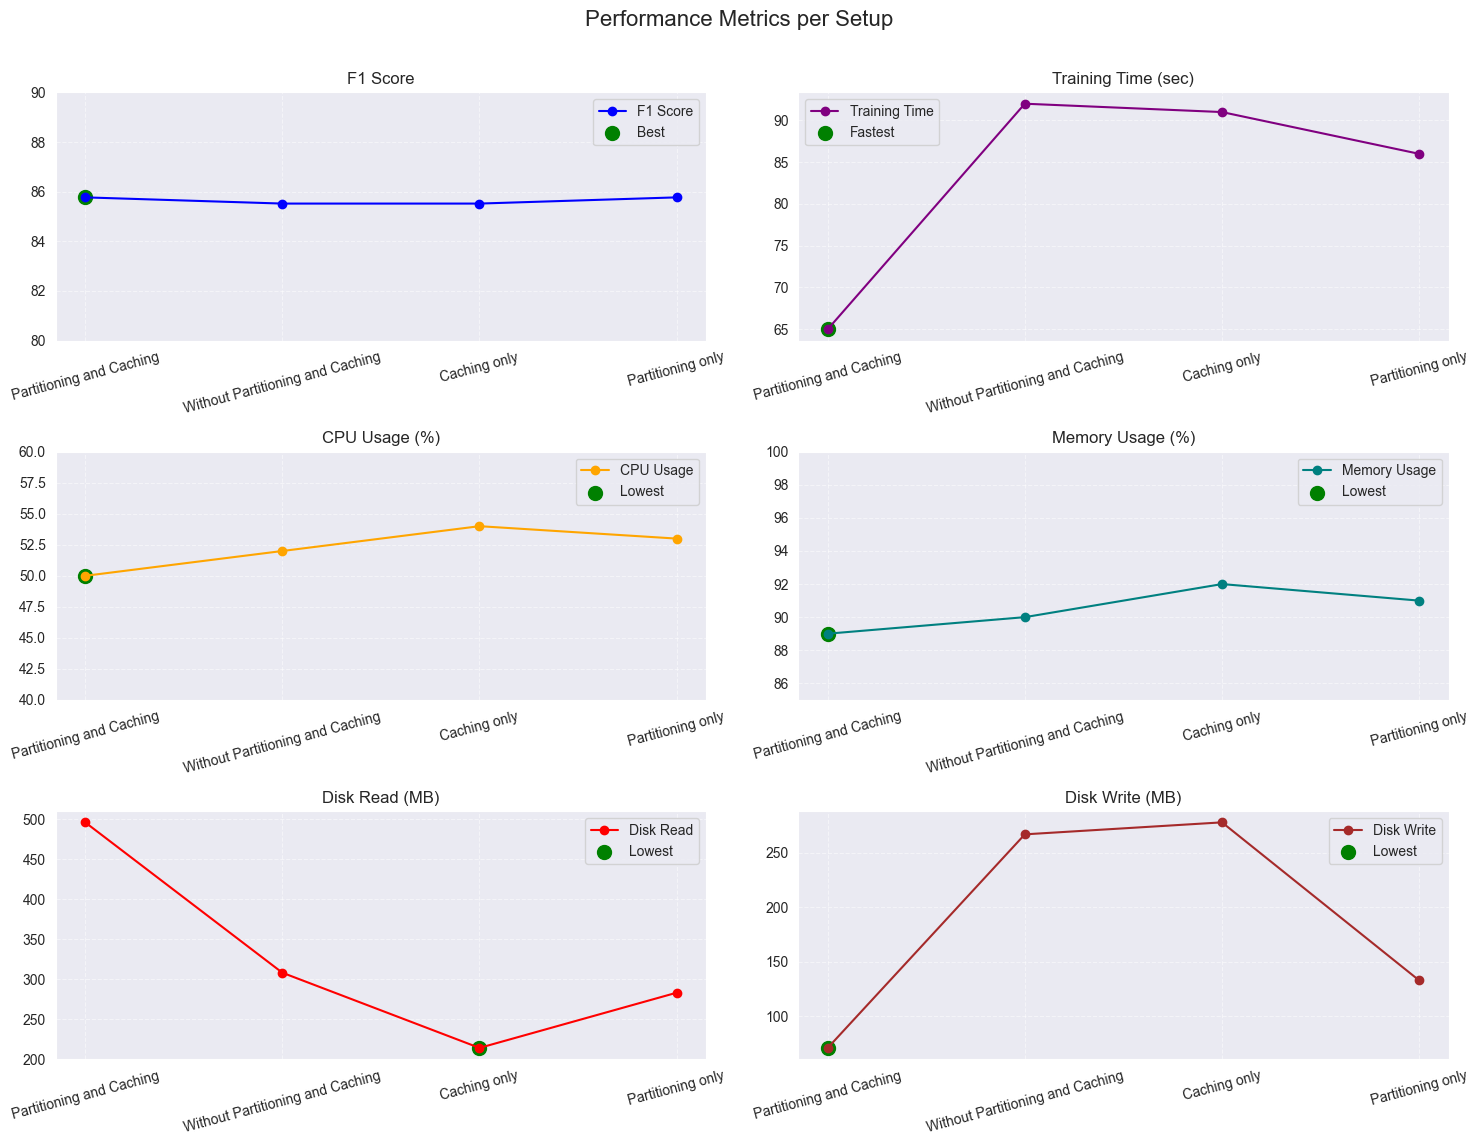

In [12]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['Partitioning and Caching','Without Partitioning and Caching', 'Caching only', 'Partitioning only']
x = np.arange(len(methods))

# Μετρικές
f1_score = [85.77, 85.52, 85.52, 85.77]
training_time = [65, 92, 91, 86]
CPU_usage = [50, 52, 54, 53]
Memory_usage = [89, 90, 92, 91]
disk_read = [496, 308, 214, 283]
disk_write = [71, 267, 278, 133]

# Δημιουργία figure με 6 υπο-διαγράμματα (3 σειρές x 2 στήλες)
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle("Performance Metrics per Setup", fontsize=16)

# --------- 1. F1 Score ---------
best_f1_idx = np.argmax(f1_score)
axs[0, 0].plot(x, f1_score, marker='o', linestyle='-', color='blue', label="F1 Score")
axs[0, 0].scatter(best_f1_idx, f1_score[best_f1_idx], color='green', s=100, label="Best")
axs[0, 0].set_title("F1 Score")
axs[0, 0].set_ylim(80, 90)
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(methods, rotation=15)
axs[0, 0].grid(True, linestyle='--', alpha=0.5)
axs[0, 0].legend()

# --------- 2. Training Time ---------
best_time_idx = np.argmin(training_time)
axs[0, 1].plot(x, training_time, marker='o', linestyle='-', color='purple', label="Training Time")
axs[0, 1].scatter(best_time_idx, training_time[best_time_idx], color='green', s=100, label="Fastest")
axs[0, 1].set_title("Training Time (sec)")
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(methods, rotation=15)
axs[0, 1].grid(True, linestyle='--', alpha=0.5)
axs[0, 1].legend()

# --------- 3. CPU Usage ---------
best_cpu_idx = np.argmin(CPU_usage)
axs[1, 0].plot(x, CPU_usage, marker='o', linestyle='-', color='orange', label="CPU Usage")
axs[1, 0].scatter(best_cpu_idx, CPU_usage[best_cpu_idx], color='green', s=100, label="Lowest")
axs[1, 0].set_title("CPU Usage (%)")
axs[1, 0].set_ylim(40, 60)
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(methods, rotation=15)
axs[1, 0].grid(True, linestyle='--', alpha=0.5)
axs[1, 0].legend()

# --------- 4. Memory Usage ---------
best_mem_idx = np.argmin(Memory_usage)
axs[1, 1].plot(x, Memory_usage, marker='o', linestyle='-', color='teal', label="Memory Usage")
axs[1, 1].scatter(best_mem_idx, Memory_usage[best_mem_idx], color='green', s=100, label="Lowest")
axs[1, 1].set_title("Memory Usage (%)")
axs[1, 1].set_ylim(85, 100)
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(methods, rotation=15)
axs[1, 1].grid(True, linestyle='--', alpha=0.5)
axs[1, 1].legend()

# --------- 5. Disk Read ---------
best_read_idx = np.argmin(disk_read)
axs[2, 0].plot(x, disk_read, marker='o', linestyle='-', color='red', label="Disk Read")
axs[2, 0].scatter(best_read_idx, disk_read[best_read_idx], color='green', s=100, label="Lowest")
axs[2, 0].set_title("Disk Read (MB)")
axs[2, 0].set_xticks(x)
axs[2, 0].set_xticklabels(methods, rotation=15)
axs[2, 0].grid(True, linestyle='--', alpha=0.5)
axs[2, 0].legend()

# --------- 6. Disk Write ---------
best_write_idx = np.argmin(disk_write)
axs[2, 1].plot(x, disk_write, marker='o', linestyle='-', color='brown', label="Disk Write")
axs[2, 1].scatter(best_write_idx, disk_write[best_write_idx], color='green', s=100, label="Lowest")
axs[2, 1].set_title("Disk Write (MB)")
axs[2, 1].set_xticks(x)
axs[2, 1].set_xticklabels(methods, rotation=15)
axs[2, 1].grid(True, linestyle='--', alpha=0.5)
axs[2, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
